In [1]:
from src.dataloading import get_preprocessed_data_loaders, get_trained_unet1
from src.train import train_ssn2v_improved
from src.visualise import plot_training_progress
import torch

c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
img_size = 256

train_loader, val_loader = get_preprocessed_data_loaders(
    base_path='C:/temp/stage1', 
    patient_ids=[0, 1, 2, 3], 
    img_size=img_size, 
    batch_size=1
)

Indexing Fused Images: 100%|██████████| 1089/1089 [00:00<00:00, 362565.25it/s]

Skipping Patient 2 due to error: [WinError 3] The system cannot find the path specified: 'C:/temp/stage1\\2\\fused'
Skipping Patient 3 due to error: [WinError 3] The system cannot find the path specified: 'C:/temp/stage1\\3\\fused'


: 

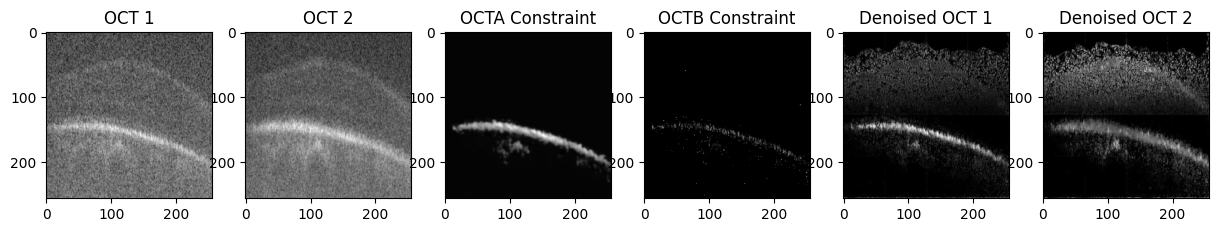

Batch 250 Losses:
Total: 0.4878
N2V: 0.3773
OCTA: 0.0111
Background: 0.0457


In [ ]:
from src.train import SSN2VStage2Tuned

device, model, criterion, optimizer = get_trained_unet1(img_size)

train = True

tuned = True
fixed = False

if tuned:
    #ssn2v_model = SSN2VStage2Tuned(model, device)
    ssn2v_model = SSN2VStage2Tuned(
        unet_model=model,
        device=device,
        alpha=2,  # Stronger OCTA constraint
        beta=0.5,   # Background control
        gamma=0.2   # Smoothness control
    )

if train:
    
    train_losses, val_losses = train_ssn2v_improved(
        img_size,
        ssn2v_model,
        train_loader,
        val_loader,
        optimizer,
        num_epochs=5,
        device=device,
        visualize_every=50,
        percentile=90
    )

In [ ]:
def load_and_test_ssn2v(img_size, checkpoint_path, device='cuda'):
    # Get base model
    _, model, _, _ = get_trained_unet1(img_size)
    
    # Initialize SSN2V model
    ssn2v_model = SSN2VStage2Tuned(
        unet_model=model,
        device=device,
        alpha=2.0,
        beta=1.0,
        gamma=0.5
    )
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load state dict into the U-Net model
    ssn2v_model.model.load_state_dict(checkpoint['model_state_dict'])
    
    return ssn2v_model

test = True


if test:

    from src.postprocessing import SSN2VPostProcessor
    from src.test import SSN2VEvaluator
    # Load trained model
    ssn2v_model = load_and_test_ssn2v(
        img_size=img_size,
        checkpoint_path='best_ssn2v_model.pth',
        device=device
    )
    
    # Process a single image
    with torch.no_grad():
        sample_image = next(iter(val_loader))['raw'].to(device)
        denoised = ssn2v_model.inference(sample_image)
        
        # Post-process
        processor = SSN2VPostProcessor(device=device)
        processed = processor.process_image(denoised.cpu().numpy()[0, 0])
        
        # Evaluate
        evaluator = SSN2VEvaluator()
        metrics = evaluator.evaluate_image(
            processed,
            sample_image.cpu().numpy()[0, 0],  # reference
            sample_image.cpu().numpy()[0, 0]   # original
        )
        
        # Visualize
        evaluator.visualize_results(
            sample_image.cpu().numpy()[0, 0],
            denoised.cpu().numpy()[0, 0],
            sample_image.cpu().numpy()[0, 0],
            processed,
        )

In [ ]:
if train:
    plot_training_progress(train_losses, val_losses)

In [ ]:
from src.test import process_stage2_example
process_stage2_example(val_loader, device, ssn2v_model)